In [45]:
import  warnings 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
warnings.filterwarnings("ignore")
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql import Window
pd.options.display.max_columns = 50

## 1. Importing Data

In [46]:
# Building spark session with desired config
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "4g") \
    .appName('flight_data_analysis') \
    .getOrCreate()



In [47]:
# Reading flight data from csv
flights_df = spark.read.csv("../flight_data/cleaned_flight_data.csv", header = True)

In [48]:
# Showing first 5 rows
flights_df.limit(5).toPandas().head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,ARRIVAL_DELAY,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME
0,AS,ANC,SEA,-11,205,194,169,1448,-22,2015-01-01 00:05:00,23:54:00,04:30:00,04:08:00
1,AA,LAX,PBI,-8,280,279,263,2330,-9,2015-01-01 00:10:00,00:02:00,07:50:00,07:41:00
2,US,SFO,CLT,-2,286,293,266,2296,5,2015-01-01 00:20:00,00:18:00,08:06:00,08:11:00
3,AA,LAX,MIA,-5,285,281,258,2342,-9,2015-01-01 00:20:00,00:15:00,08:05:00,07:56:00
4,AS,SEA,ANC,-1,235,215,199,1448,-21,2015-01-01 00:25:00,00:24:00,03:20:00,02:59:00


## 2. Checking for null values

In [54]:
# Getiing all the null values from spark DataFrame
null_columns = flights_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in flights_df.columns]
   )


In [55]:
# Calculating the % of missing value
pc_missing = []
null_value = null_columns.toPandas()
rows = flights_df.count()
for column in null_value:
    pc_missing.append((column,(null_value[column][0]/rows)*100))

In [56]:
# Printing all together
columns = pd.DataFrame(flights_df.dtypes).set_index(0)[1]
null_value_percentage = pd.DataFrame(pc_missing).set_index(0)[1]
column_info=pd.DataFrame(columns).T.rename(index={1:'column data type'})
column_info=column_info.append(null_value.rename(index={0:'null values (nb)'}))
column_info=column_info.append(null_value_percentage.rename(index='null values (%)'))                       
column_info


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,ARRIVAL_DELAY,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME
column data type,string,string,string,string,string,string,string,string,string,string,string,string,string
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


___
## 2. Comparing airlines


As said earlier, the **AIRLINE** variable contains the airline abreviations. Their full names can be retrieved from the `airlines.csv` file.

In [37]:
airlines_names = spark.read.csv("../flight_data/airlines.csv", header = True)
rows = airlines_names.count()
column =  len(airlines_names.columns)
print('Dataframe dimensions:', (rows,column))
airlines_names.printSchema()

Dataframe dimensions: (14, 2)
root
 |-- IATA_CODE: string (nullable = true)
 |-- AIRLINE: string (nullable = true)



In [38]:
airlines_names = airlines_names.toPandas()
airlines_names = airlines_names.reset_index(drop=True)
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


For further use, I put the content of this this dataframe in a dictionary:

In [39]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [40]:
abbr_companies

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

___
### 2.1 Basic statistical description of airlines

As a first step, I consider all the flights from all carriers. Here, the aim is to classify the airlines with respect to their punctuality and for that purpose, I compute a few basic statisticial parameters:

In [41]:
from pyspark.sql.functions import avg,max,min,mean,count

flights_df = flights_df.groupby(col("AIRLINE")).agg(avg(col("DEPARTURE_DELAY")).alias("mean"),count(col("DEPARTURE_DELAY")).alias("count")).orderBy(
    col("mean").asc())

In [42]:
# printing the ranking based on the mean
global_stats = flights_df.toPandas()
global_stats

,AIRLINE,mean,count
0,HA,0.469918,76041
1,AS,1.718926,171439
2,US,6.081000,194223
3,DL,7.313300,870275
4,OO,7.736083,576814
5,EV,8.615598,554752
6,AA,8.826106,712935
7,VX,8.993486,61248
8,MQ,9.967187,278791
9,WN,10.517183,1242403


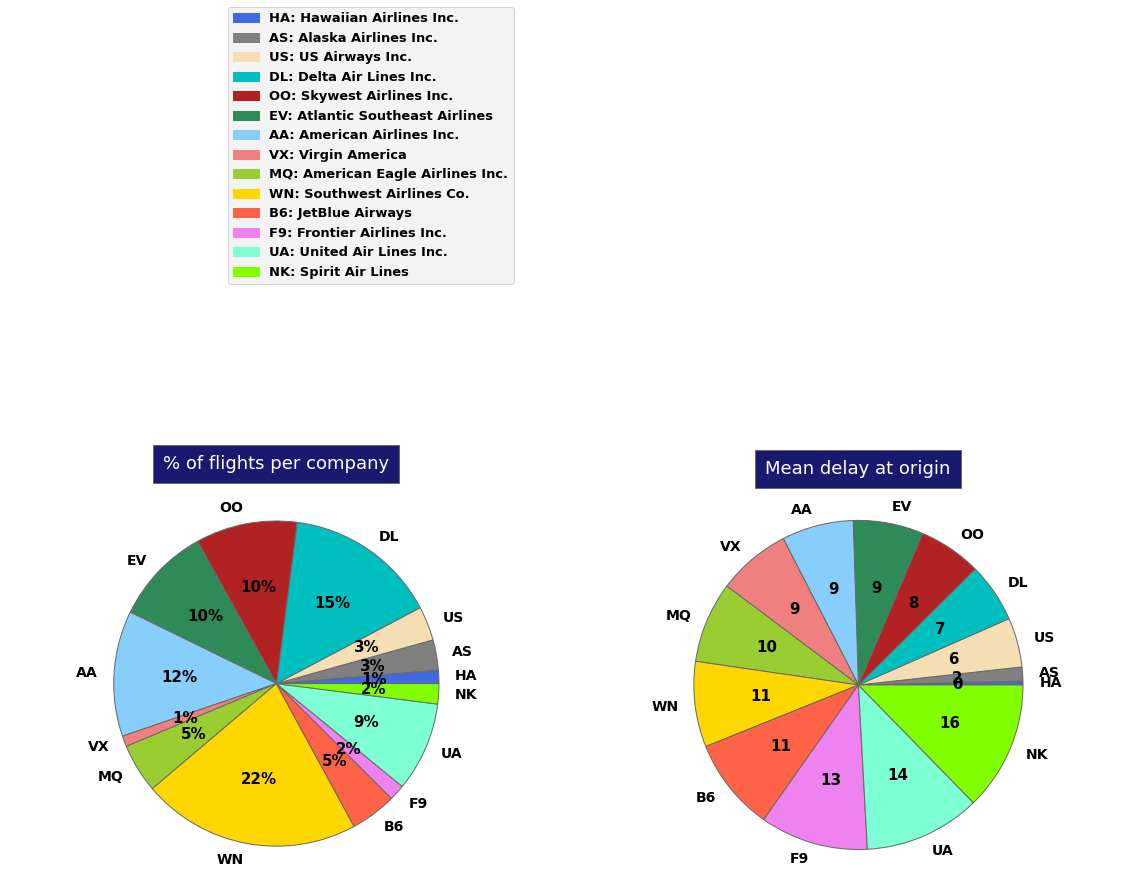

In [43]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches

#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [global_stats["AIRLINE"][s] for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':10},
              color = 'w',fontsize=18,  pad=35)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    code = global_stats["AIRLINE"][global_stats.index[i]] 
   
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = code + ': ' + abbr_companies[code]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values

explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * np.sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':10 },
              color='w', fontsize=18, pad = 30)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
plt.tight_layout(w_pad=3) 

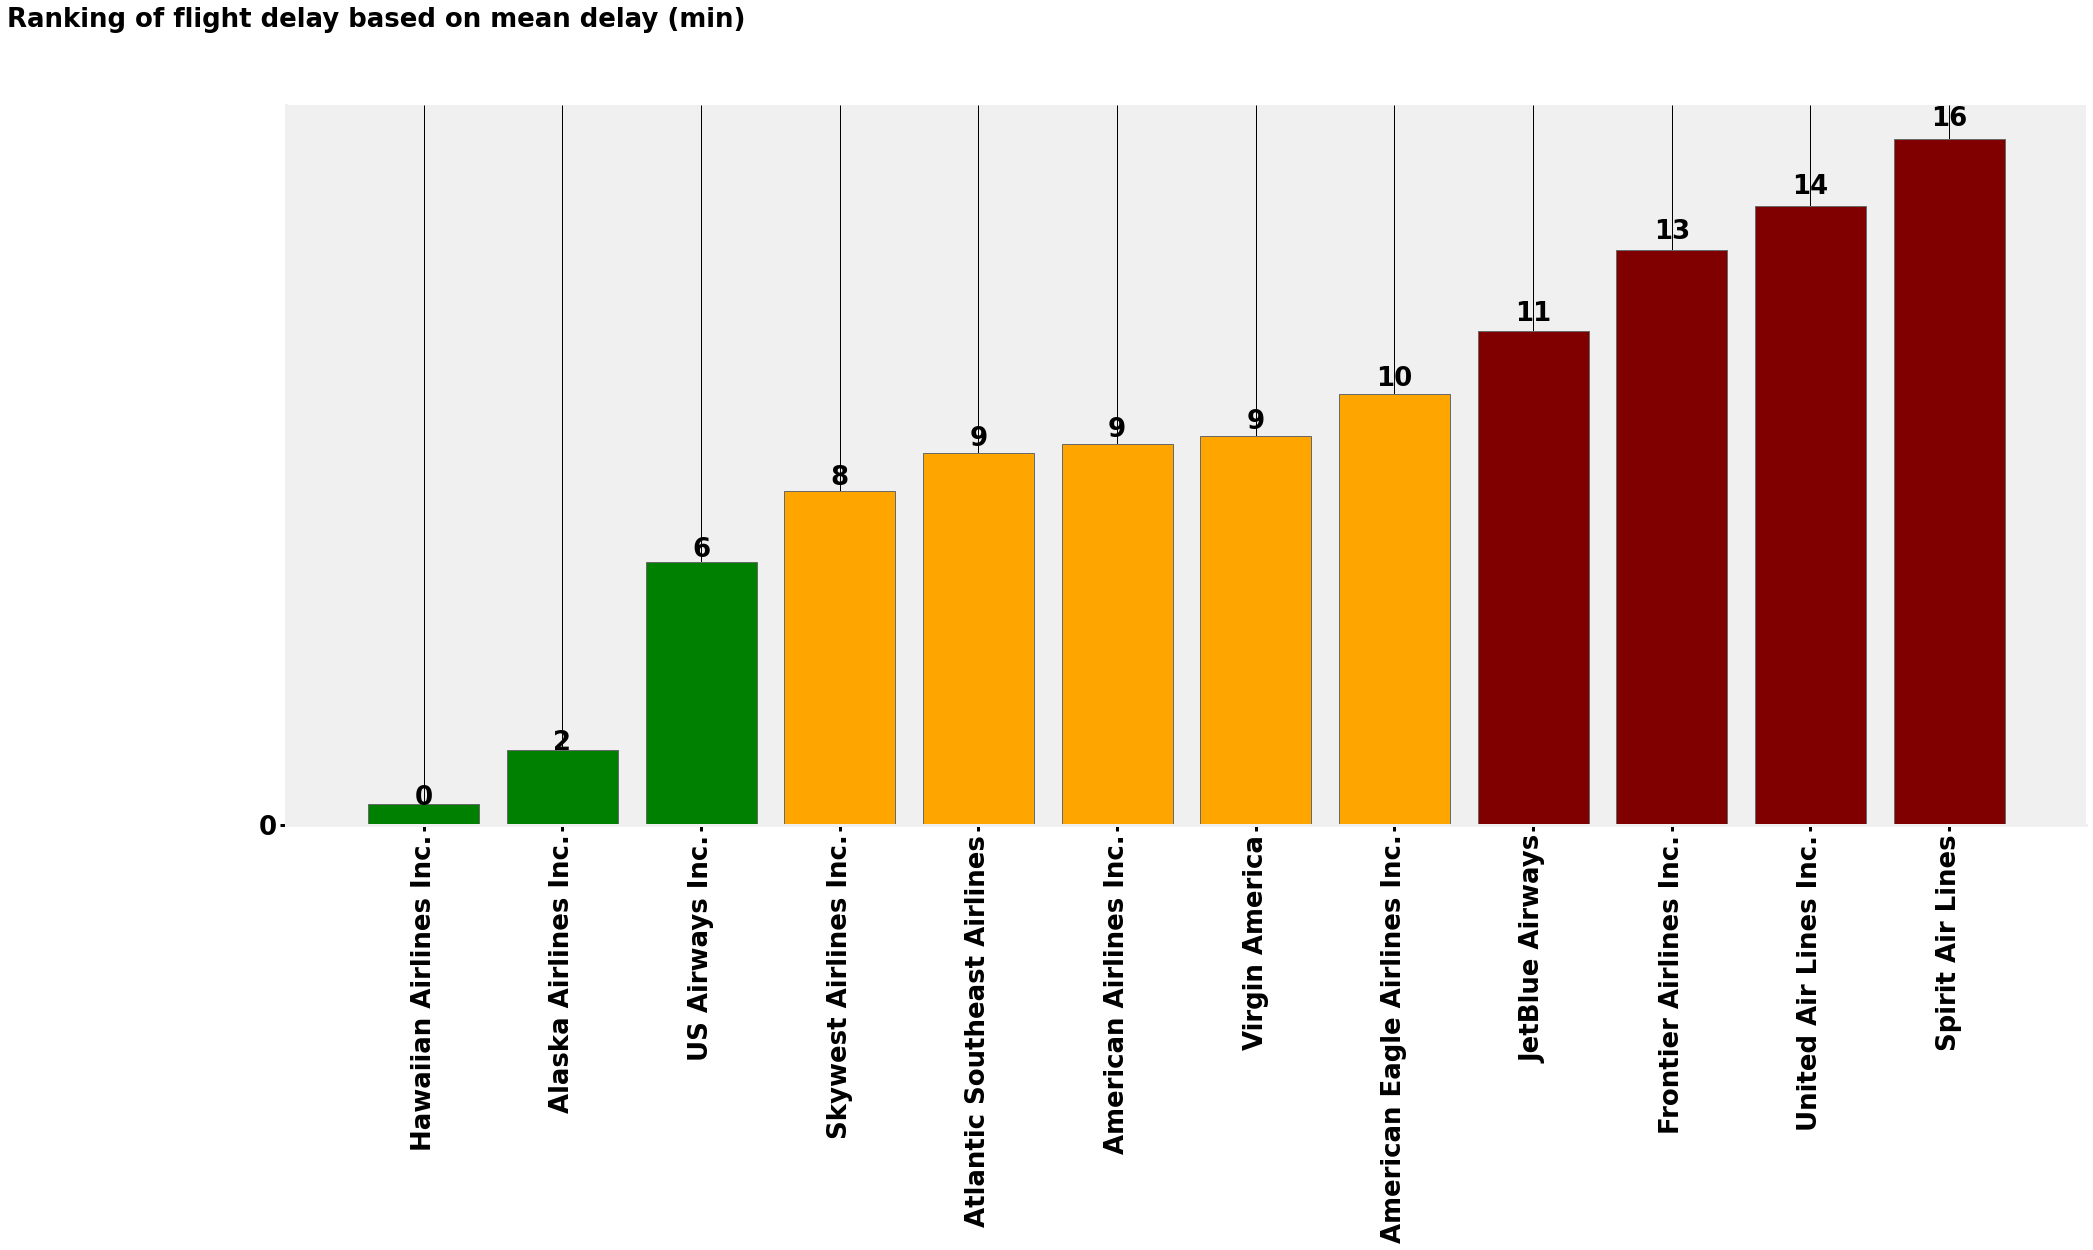

In [44]:
fig = plt.figure(figsize = (25, 10))
ax = fig.add_axes([0, 0, 1, 1])
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = global_stats.loc[:, ['AIRLINE', 'mean']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)

ax.bar(x = df2['AIRLINE'][:3], height = df2['mean'][:3], color = 'green')
ax.bar(x = df2['AIRLINE'][4:9], height = df2['mean'][4:9], color = 'orange')
ax.bar(x = df2['AIRLINE'][10:], height = df2['mean'][10:], color = 'maroon')

# axis
sns.despine()

# annotate
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}'.format(height), (x + width/2, y + height*1.02), ha='center', color = 'black', fontsize = 26, fontweight = 'bold') 

# ticks
plt.yticks(range(0, 1, 65))
plt.tick_params(direction='out', length=6, width=3, colors='black', grid_color='black', labelsize = 26)
plt.xticks(rotation = 90)

# title
plt.title('Ranking of flight delay based on mean delay (min)', x = 0.05, y = 1.1, color = 'black', fontsize = 26, fontweight = 'bold')

plt.show()